# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


In [6]:
l = FullyConnectedLayer(3, 4)
res = l.forward(X)
print(res)

[[-0.00297304  0.00250264 -0.00026903  0.00533588]
 [ 0.00140251 -0.00231468 -0.00336427 -0.00136576]]


In [7]:
train_X.shape

(9000, 3072)

## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [8]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for l1_w
Gradient check passed!
Checking gradient for l1_b
Gradient check passed!
Checking gradient for l2_w
Gradient check passed!
Checking gradient for l2_b
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [9]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for l1_w
Gradient check passed!
Checking gradient for l1_b
Gradient check passed!
Checking gradient for l2_w
Gradient check passed!
Checking gradient for l2_b
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [10]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.16666666666666666

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [11]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 45.935703, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.705239, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.927980, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 46.058940, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.724573, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.493810, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.143701, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.705971, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.901959, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.887821, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.013442, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.129141, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.149481, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.986460, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.300729, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.7

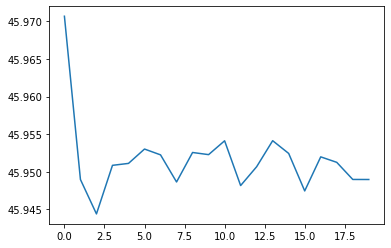

In [12]:
plt.plot(loss_history)

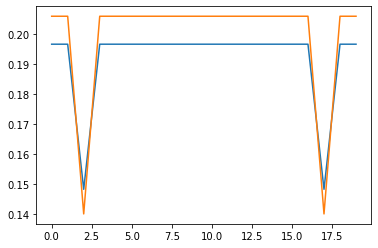

In [13]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [14]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 41.434652, Train accuracy: 0.324889, val accuracy: 0.341000
Loss: 43.098394, Train accuracy: 0.533778, val accuracy: 0.538000
Loss: 49.653042, Train accuracy: 0.477222, val accuracy: 0.470000
Loss: 31.086640, Train accuracy: 0.593778, val accuracy: 0.590000
Loss: 34.675877, Train accuracy: 0.575000, val accuracy: 0.569000
Loss: 51.776259, Train accuracy: 0.492556, val accuracy: 0.489000
Loss: 34.991629, Train accuracy: 0.589111, val accuracy: 0.606000
Loss: 35.295137, Train accuracy: 0.592444, val accuracy: 0.576000
Loss: 41.000906, Train accuracy: 0.599778, val accuracy: 0.595000
Loss: 34.309963, Train accuracy: 0.614111, val accuracy: 0.594000
Loss: 34.084474, Train accuracy: 0.532889, val accuracy: 0.551000
Loss: 30.093477, Train accuracy: 0.669111, val accuracy: 0.657000
Loss: 50.203479, Train accuracy: 0.564000, val accuracy: 0.545000
Loss: 36.393499, Train accuracy: 0.591667, val accuracy: 0.585000
Loss: 40.909470, Train accuracy: 0.610222, val accuracy: 0.605000
Loss: 36.5

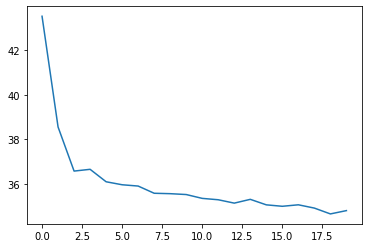

In [15]:
plt.plot(loss_history)

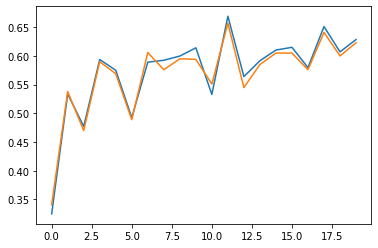

In [16]:
plt.plot(train_history)
plt.plot(val_history)

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [17]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()


Loss: 44.724276, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 43.431613, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.521125, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 39.192398, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 40.442832, Train accuracy: 0.207444, val accuracy: 0.215000
Loss: 44.966102, Train accuracy: 0.254556, val accuracy: 0.258000
Loss: 36.099310, Train accuracy: 0.278444, val accuracy: 0.280000
Loss: 39.787739, Train accuracy: 0.305222, val accuracy: 0.314000
Loss: 37.015723, Train accuracy: 0.353333, val accuracy: 0.349000
Loss: 37.193913, Train accuracy: 0.397889, val accuracy: 0.394000
Loss: 33.648729, Train accuracy: 0.432556, val accuracy: 0.424000
Loss: 33.812997, Train accuracy: 0.464778, val accuracy: 0.450000
Loss: 26.709668, Train accuracy: 0.495556, val accuracy: 0.479000
Loss: 31.556996, Train accuracy: 0.525778, val accuracy: 0.521000
Loss: 35.514641, Train accuracy: 0.550556, val accuracy: 0.544000
Loss: 32.5

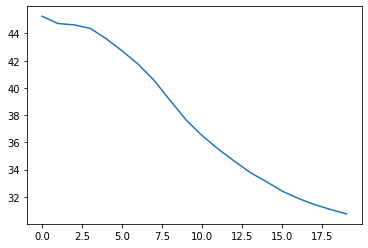

In [18]:
plt.plot(loss_history)

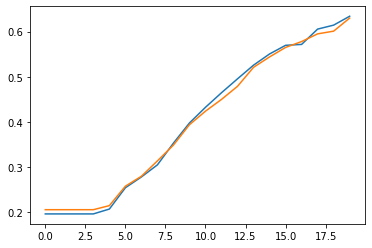

In [19]:
plt.plot(train_history)
plt.plot(val_history)

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [20]:
train_X.shape

(9000, 3072)

In [21]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-3, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 11.550728, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.542592, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.534920, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.546951, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.539629, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.543458, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.524038, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.512798, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.527767, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.513630, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.486350, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.527494, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.482096, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.498734, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.480524, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.4

Loss: 10.527860, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.850661, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 11.320990, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 11.006275, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.547378, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 11.186801, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.306821, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.310425, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.799640, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 11.179162, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.220845, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 9.788892, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 11.768264, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 9.919965, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.918659, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.020

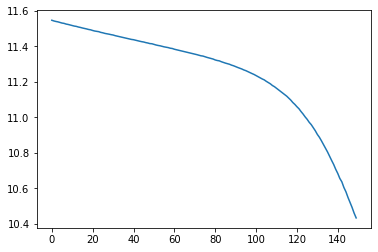

In [22]:
plt.plot(loss_history)

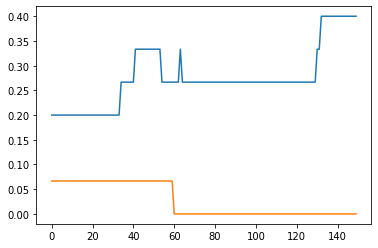

In [23]:
plt.plot(train_history)
plt.plot(val_history)

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [24]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 11.514950, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.490038, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.398136, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.466148, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.394717, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.585644, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.364329, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.426510, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.496480, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.396317, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.446526, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.981934, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.889920, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 11.084386, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.579487, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.0

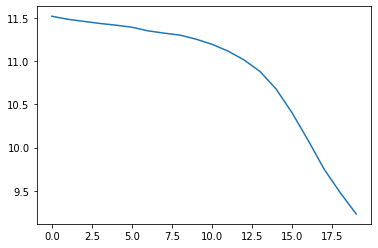

In [25]:
plt.plot(loss_history)

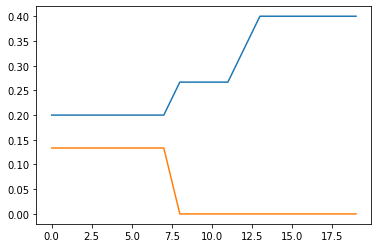

In [26]:
plt.plot(train_history)
plt.plot(val_history)

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [27]:
# Let's train the best one-hidden-layer network we can


learning_rates = [1e-3, 1e-4] #1e-5
reg_strength = [1e-3, 1e-4]
learning_rate_decay = [0.85, 0.9, 0.999]
hidden_layer_size = [128] #50, 100
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None
best_idx = 0
idx = -1

loss_history = []
train_history = []
val_history = []

dataset = Dataset(train_X, train_y, val_X, val_y)

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
for lr in learning_rates:
    for rs in reg_strength:
        for lrd in learning_rate_decay:
            for hls in hidden_layer_size:
                print(lr, rs, lrd, hls)
                idx += 1
                model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hls, reg = rs)
                trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=lr, num_epochs=num_epochs, batch_size=batch_size, learning_rate_decay=lrd)
                loss_history_cur, train_history_cur, val_history_cur = trainer.fit()
                max_val = np.max(val_history_cur)
                loss_history.append(loss_history_cur)
                train_history.append(train_history_cur)
                val_history.append(val_history_cur)
                if best_classifier == None or best_val_accuracy < max_val:
                        best_classifier = model
                        best_val_accuracy = max_val                        
                        best_lr = lr
                        best_reg = rs
                        best_lrd = lrd
                        best_hls = hls
                        best_idx = idx
                        #loss_history = loss_history_cur
                        #train_history = train_history_cur
                        #val_history = val_history_cur


print('best validation accuracy achieved: %f, learning_rate: %f, reg: %f, decay: %f, layers: %f' % 
      (best_val_accuracy, best_lr, best_reg, best_lrd, best_hls))

0.001 0.001 0.85 100
Loss: 86.406009, Train accuracy: 0.277556, val accuracy: 0.285000
Loss: 59.199459, Train accuracy: 0.559222, val accuracy: 0.550000
Loss: 66.567669, Train accuracy: 0.616556, val accuracy: 0.601000
Loss: 38.546318, Train accuracy: 0.681222, val accuracy: 0.672000
Loss: 32.854719, Train accuracy: 0.723111, val accuracy: 0.682000
Loss: 38.685383, Train accuracy: 0.734889, val accuracy: 0.676000
Loss: 38.610901, Train accuracy: 0.735556, val accuracy: 0.691000
Loss: 29.425925, Train accuracy: 0.778111, val accuracy: 0.716000
Loss: 35.356542, Train accuracy: 0.778111, val accuracy: 0.722000
Loss: 36.995896, Train accuracy: 0.795556, val accuracy: 0.730000
Loss: 25.508291, Train accuracy: 0.817111, val accuracy: 0.746000
Loss: 21.454051, Train accuracy: 0.814556, val accuracy: 0.726000
Loss: 28.705106, Train accuracy: 0.835111, val accuracy: 0.745000
Loss: 29.948108, Train accuracy: 0.842444, val accuracy: 0.748000
Loss: 20.765393, Train accuracy: 0.847444, val accuracy

Loss: 22.684316, Train accuracy: 0.876889, val accuracy: 0.761000
Loss: 20.374296, Train accuracy: 0.876889, val accuracy: 0.761000
Loss: 8.761822, Train accuracy: 0.876889, val accuracy: 0.761000
Loss: 17.689413, Train accuracy: 0.876889, val accuracy: 0.761000
Loss: 24.092079, Train accuracy: 0.876889, val accuracy: 0.761000
Loss: 21.447328, Train accuracy: 0.876889, val accuracy: 0.761000
Loss: 9.551622, Train accuracy: 0.876889, val accuracy: 0.761000
Loss: 16.058480, Train accuracy: 0.876889, val accuracy: 0.761000
Loss: 15.832112, Train accuracy: 0.876889, val accuracy: 0.761000
Loss: 14.164069, Train accuracy: 0.876889, val accuracy: 0.761000
Loss: 20.931649, Train accuracy: 0.876889, val accuracy: 0.761000
Loss: 18.549066, Train accuracy: 0.876889, val accuracy: 0.761000
Loss: 25.442300, Train accuracy: 0.876889, val accuracy: 0.761000
Loss: 11.611545, Train accuracy: 0.876889, val accuracy: 0.761000
Loss: 13.588232, Train accuracy: 0.876889, val accuracy: 0.761000
Loss: 15.761

Loss: 16.880732, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 18.646699, Train accuracy: 0.885111, val accuracy: 0.765000
Loss: 13.692829, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 13.527060, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 15.466158, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 21.078636, Train accuracy: 0.885111, val accuracy: 0.765000
Loss: 14.363664, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 17.093784, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 14.370314, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 15.072351, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 10.536834, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 17.538897, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 16.351098, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 23.242940, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 18.459829, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 14.7

Loss: 19.899081, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 16.369080, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 20.638840, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 19.232113, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 16.395624, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 16.763954, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 15.804832, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 11.583810, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 14.196217, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 15.112716, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 24.168079, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 20.874203, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 10.863847, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 16.002510, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 9.247990, Train accuracy: 0.885222, val accuracy: 0.765000
Loss: 10.70

Loss: 11.649432, Train accuracy: 0.934444, val accuracy: 0.764000
Loss: 9.021160, Train accuracy: 0.934444, val accuracy: 0.764000
Loss: 12.063032, Train accuracy: 0.934444, val accuracy: 0.764000
Loss: 12.279316, Train accuracy: 0.934444, val accuracy: 0.764000
Loss: 7.258110, Train accuracy: 0.934444, val accuracy: 0.764000
Loss: 9.795449, Train accuracy: 0.934444, val accuracy: 0.764000
Loss: 7.056206, Train accuracy: 0.934444, val accuracy: 0.764000
Loss: 11.240529, Train accuracy: 0.934444, val accuracy: 0.764000
Loss: 13.870146, Train accuracy: 0.934444, val accuracy: 0.764000
Loss: 6.591072, Train accuracy: 0.934444, val accuracy: 0.764000
Loss: 18.029973, Train accuracy: 0.934444, val accuracy: 0.764000
Loss: 14.040089, Train accuracy: 0.934444, val accuracy: 0.764000
Loss: 9.655093, Train accuracy: 0.934444, val accuracy: 0.764000
Loss: 7.022981, Train accuracy: 0.934444, val accuracy: 0.764000
Loss: 15.186228, Train accuracy: 0.934444, val accuracy: 0.764000
Loss: 14.862585, 

Loss: 10.363264, Train accuracy: 0.918556, val accuracy: 0.763000
Loss: 13.667815, Train accuracy: 0.921556, val accuracy: 0.766000
Loss: 13.497074, Train accuracy: 0.925889, val accuracy: 0.768000
Loss: 28.659151, Train accuracy: 0.926111, val accuracy: 0.758000
Loss: 18.047889, Train accuracy: 0.928222, val accuracy: 0.762000
Loss: 6.748712, Train accuracy: 0.930333, val accuracy: 0.765000
Loss: 13.155882, Train accuracy: 0.930111, val accuracy: 0.755000
Loss: 16.680266, Train accuracy: 0.931111, val accuracy: 0.765000
Loss: 7.207203, Train accuracy: 0.934111, val accuracy: 0.764000
Loss: 11.025767, Train accuracy: 0.933889, val accuracy: 0.761000
Loss: 15.960797, Train accuracy: 0.934000, val accuracy: 0.768000
Loss: 11.176962, Train accuracy: 0.937000, val accuracy: 0.765000
Loss: 7.259469, Train accuracy: 0.937333, val accuracy: 0.767000
Loss: 12.466524, Train accuracy: 0.936667, val accuracy: 0.766000
Loss: 12.849291, Train accuracy: 0.937333, val accuracy: 0.767000
Loss: 5.86026

Loss: 6.747049, Train accuracy: 0.943778, val accuracy: 0.767000
Loss: 9.591847, Train accuracy: 0.943778, val accuracy: 0.767000
Loss: 13.062847, Train accuracy: 0.943778, val accuracy: 0.767000
Loss: 8.015200, Train accuracy: 0.943778, val accuracy: 0.767000
Loss: 5.171750, Train accuracy: 0.943778, val accuracy: 0.767000
Loss: 9.253913, Train accuracy: 0.943778, val accuracy: 0.767000
Loss: 9.095547, Train accuracy: 0.943778, val accuracy: 0.767000
Loss: 8.920130, Train accuracy: 0.943778, val accuracy: 0.767000
Loss: 12.363960, Train accuracy: 0.943778, val accuracy: 0.767000
Loss: 5.224849, Train accuracy: 0.943778, val accuracy: 0.767000
Loss: 12.868802, Train accuracy: 0.943778, val accuracy: 0.767000
Loss: 7.741576, Train accuracy: 0.943778, val accuracy: 0.767000
Loss: 9.218657, Train accuracy: 0.943778, val accuracy: 0.767000
Loss: 9.517850, Train accuracy: 0.943778, val accuracy: 0.767000
Loss: 9.736451, Train accuracy: 0.943778, val accuracy: 0.767000
Loss: 11.793778, Train

Loss: 17.523511, Train accuracy: 0.925778, val accuracy: 0.727000
Loss: 18.978382, Train accuracy: 0.955222, val accuracy: 0.741000
Loss: 7.661979, Train accuracy: 0.956667, val accuracy: 0.748000
Loss: 12.698497, Train accuracy: 0.920444, val accuracy: 0.713000
Loss: 15.331334, Train accuracy: 0.928222, val accuracy: 0.729000
Loss: 16.754032, Train accuracy: 0.934556, val accuracy: 0.731000
Loss: 28.293316, Train accuracy: 0.941333, val accuracy: 0.740000
Loss: 11.212740, Train accuracy: 0.942889, val accuracy: 0.747000
Loss: 8.633548, Train accuracy: 0.925778, val accuracy: 0.722000
Loss: 15.005179, Train accuracy: 0.936333, val accuracy: 0.731000
Loss: 10.664009, Train accuracy: 0.932556, val accuracy: 0.715000
Loss: 19.600356, Train accuracy: 0.940222, val accuracy: 0.729000
Loss: 22.819069, Train accuracy: 0.941444, val accuracy: 0.737000
Loss: 8.622716, Train accuracy: 0.957889, val accuracy: 0.749000
Loss: 20.704624, Train accuracy: 0.949333, val accuracy: 0.754000
Loss: 9.45075

Loss: 7.436286, Train accuracy: 0.999556, val accuracy: 0.761000
Loss: 7.369951, Train accuracy: 0.999778, val accuracy: 0.765000
0.001 0.001 0.999 128
Loss: 85.392992, Train accuracy: 0.298111, val accuracy: 0.300000
Loss: 50.824163, Train accuracy: 0.508111, val accuracy: 0.517000
Loss: 50.901650, Train accuracy: 0.605111, val accuracy: 0.607000
Loss: 43.193263, Train accuracy: 0.628778, val accuracy: 0.604000
Loss: 47.914824, Train accuracy: 0.640778, val accuracy: 0.601000
Loss: 41.512639, Train accuracy: 0.691000, val accuracy: 0.653000
Loss: 38.104763, Train accuracy: 0.739556, val accuracy: 0.690000
Loss: 34.687021, Train accuracy: 0.701778, val accuracy: 0.624000
Loss: 57.766361, Train accuracy: 0.772889, val accuracy: 0.700000
Loss: 36.638947, Train accuracy: 0.767778, val accuracy: 0.691000
Loss: 22.185748, Train accuracy: 0.774444, val accuracy: 0.696000
Loss: 34.872898, Train accuracy: 0.799667, val accuracy: 0.699000
Loss: 31.545393, Train accuracy: 0.807000, val accuracy:

Loss: 9.720224, Train accuracy: 0.970222, val accuracy: 0.751000
Loss: 7.168448, Train accuracy: 0.973556, val accuracy: 0.758000
Loss: 10.971784, Train accuracy: 0.955333, val accuracy: 0.723000
Loss: 9.730719, Train accuracy: 0.974000, val accuracy: 0.727000
Loss: 38.597080, Train accuracy: 0.919111, val accuracy: 0.706000
Loss: 8.209964, Train accuracy: 0.971000, val accuracy: 0.743000
Loss: 15.019890, Train accuracy: 0.949111, val accuracy: 0.722000
Loss: 10.609708, Train accuracy: 0.970111, val accuracy: 0.752000
Loss: 18.663771, Train accuracy: 0.941778, val accuracy: 0.730000
Loss: 17.900752, Train accuracy: 0.962222, val accuracy: 0.735000
Loss: 7.991327, Train accuracy: 0.975889, val accuracy: 0.747000
Loss: 11.502019, Train accuracy: 0.973111, val accuracy: 0.731000
Loss: 10.417049, Train accuracy: 0.978222, val accuracy: 0.755000
Loss: 12.521001, Train accuracy: 0.972889, val accuracy: 0.747000
Loss: 8.095166, Train accuracy: 0.973000, val accuracy: 0.745000
Loss: 25.982054,

Loss: 15.049804, Train accuracy: 0.880111, val accuracy: 0.752000
Loss: 14.085753, Train accuracy: 0.880222, val accuracy: 0.753000
Loss: 23.064172, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 12.082789, Train accuracy: 0.880222, val accuracy: 0.753000
Loss: 17.785604, Train accuracy: 0.880222, val accuracy: 0.753000
Loss: 15.874400, Train accuracy: 0.880222, val accuracy: 0.753000
Loss: 16.089401, Train accuracy: 0.880222, val accuracy: 0.753000
Loss: 22.423440, Train accuracy: 0.880222, val accuracy: 0.753000
Loss: 15.843272, Train accuracy: 0.880000, val accuracy: 0.753000
Loss: 10.488177, Train accuracy: 0.880222, val accuracy: 0.753000
Loss: 14.649966, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 12.872198, Train accuracy: 0.880444, val accuracy: 0.753000
Loss: 11.432707, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 20.618095, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 33.609129, Train accuracy: 0.880222, val accuracy: 0.753000
Loss: 21.2

Loss: 14.473976, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 20.477897, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 19.134920, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 24.581286, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 17.020699, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 16.724841, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 9.664717, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 9.886077, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 24.814492, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 12.923097, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 18.434591, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 16.176596, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 17.735959, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 19.688682, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 18.116138, Train accuracy: 0.880333, val accuracy: 0.753000
Loss: 9.3140

Loss: 15.789248, Train accuracy: 0.892222, val accuracy: 0.763000
Loss: 14.866822, Train accuracy: 0.892222, val accuracy: 0.763000
Loss: 11.988543, Train accuracy: 0.892222, val accuracy: 0.763000
Loss: 17.299457, Train accuracy: 0.892222, val accuracy: 0.763000
Loss: 20.693865, Train accuracy: 0.892222, val accuracy: 0.763000
Loss: 14.092029, Train accuracy: 0.892222, val accuracy: 0.763000
Loss: 17.804139, Train accuracy: 0.892222, val accuracy: 0.763000
Loss: 16.986435, Train accuracy: 0.892222, val accuracy: 0.763000
Loss: 18.234838, Train accuracy: 0.892222, val accuracy: 0.763000
Loss: 20.951640, Train accuracy: 0.892222, val accuracy: 0.763000
Loss: 10.339420, Train accuracy: 0.892222, val accuracy: 0.763000
Loss: 17.846124, Train accuracy: 0.892222, val accuracy: 0.763000
Loss: 15.533262, Train accuracy: 0.892222, val accuracy: 0.763000
Loss: 12.102301, Train accuracy: 0.892222, val accuracy: 0.763000
Loss: 7.991653, Train accuracy: 0.892222, val accuracy: 0.763000
Loss: 19.56

Loss: 13.265804, Train accuracy: 0.901778, val accuracy: 0.773000
Loss: 14.417710, Train accuracy: 0.900889, val accuracy: 0.767000
Loss: 15.592845, Train accuracy: 0.906222, val accuracy: 0.770000
Loss: 15.930434, Train accuracy: 0.910556, val accuracy: 0.781000
Loss: 11.059678, Train accuracy: 0.913444, val accuracy: 0.779000
Loss: 8.755460, Train accuracy: 0.911778, val accuracy: 0.779000
Loss: 10.404765, Train accuracy: 0.913333, val accuracy: 0.772000
Loss: 13.351916, Train accuracy: 0.917111, val accuracy: 0.776000
Loss: 11.213544, Train accuracy: 0.918000, val accuracy: 0.782000
Loss: 15.564708, Train accuracy: 0.919667, val accuracy: 0.775000
Loss: 9.255924, Train accuracy: 0.920333, val accuracy: 0.778000
Loss: 12.441468, Train accuracy: 0.919000, val accuracy: 0.771000
Loss: 22.266418, Train accuracy: 0.921889, val accuracy: 0.777000
Loss: 10.951913, Train accuracy: 0.921667, val accuracy: 0.781000
Loss: 13.845287, Train accuracy: 0.922889, val accuracy: 0.775000
Loss: 5.8979

Loss: 5.660644, Train accuracy: 0.928111, val accuracy: 0.776000
Loss: 8.766168, Train accuracy: 0.928111, val accuracy: 0.776000
Loss: 8.654286, Train accuracy: 0.928111, val accuracy: 0.776000
Loss: 10.599448, Train accuracy: 0.928111, val accuracy: 0.776000
Loss: 15.213282, Train accuracy: 0.928111, val accuracy: 0.776000
Loss: 17.805140, Train accuracy: 0.928111, val accuracy: 0.776000
Loss: 9.678623, Train accuracy: 0.928111, val accuracy: 0.776000
Loss: 7.729847, Train accuracy: 0.928111, val accuracy: 0.776000
Loss: 10.722669, Train accuracy: 0.928111, val accuracy: 0.776000
Loss: 9.312083, Train accuracy: 0.928111, val accuracy: 0.776000
Loss: 15.841507, Train accuracy: 0.928111, val accuracy: 0.776000
Loss: 12.472260, Train accuracy: 0.928111, val accuracy: 0.776000
Loss: 9.658087, Train accuracy: 0.928111, val accuracy: 0.776000
Loss: 14.023594, Train accuracy: 0.928111, val accuracy: 0.776000
Loss: 8.964793, Train accuracy: 0.928111, val accuracy: 0.776000
Loss: 4.775269, Tr

Loss: 6.243966, Train accuracy: 0.947556, val accuracy: 0.769000
Loss: 8.341572, Train accuracy: 0.947556, val accuracy: 0.770000
Loss: 11.276730, Train accuracy: 0.947556, val accuracy: 0.770000
Loss: 7.311168, Train accuracy: 0.947556, val accuracy: 0.770000
Loss: 9.037182, Train accuracy: 0.947556, val accuracy: 0.770000
Loss: 14.368123, Train accuracy: 0.947556, val accuracy: 0.770000
Loss: 7.767846, Train accuracy: 0.947556, val accuracy: 0.770000
Loss: 9.680975, Train accuracy: 0.947667, val accuracy: 0.769000
Loss: 15.797834, Train accuracy: 0.947556, val accuracy: 0.769000
Loss: 10.760222, Train accuracy: 0.947556, val accuracy: 0.769000
Loss: 5.769264, Train accuracy: 0.947556, val accuracy: 0.769000
Loss: 6.529237, Train accuracy: 0.947667, val accuracy: 0.770000
Loss: 8.856840, Train accuracy: 0.947667, val accuracy: 0.770000
Loss: 10.639362, Train accuracy: 0.947556, val accuracy: 0.769000
Loss: 20.702307, Train accuracy: 0.947556, val accuracy: 0.769000
Loss: 4.763049, Tra

Loss: 7.439871, Train accuracy: 0.947556, val accuracy: 0.769000
Loss: 7.462251, Train accuracy: 0.947556, val accuracy: 0.769000
Loss: 8.854633, Train accuracy: 0.947556, val accuracy: 0.769000
0.001 0.0001 0.999 100
Loss: 82.813848, Train accuracy: 0.285111, val accuracy: 0.292000
Loss: 65.071016, Train accuracy: 0.487778, val accuracy: 0.505000
Loss: 47.924942, Train accuracy: 0.574778, val accuracy: 0.583000
Loss: 38.745068, Train accuracy: 0.612667, val accuracy: 0.601000
Loss: 43.013343, Train accuracy: 0.697222, val accuracy: 0.646000
Loss: 42.316831, Train accuracy: 0.686111, val accuracy: 0.657000
Loss: 47.673664, Train accuracy: 0.729667, val accuracy: 0.674000
Loss: 48.780297, Train accuracy: 0.731444, val accuracy: 0.673000
Loss: 33.568164, Train accuracy: 0.768222, val accuracy: 0.699000
Loss: 43.839530, Train accuracy: 0.771556, val accuracy: 0.693000
Loss: 27.823964, Train accuracy: 0.777889, val accuracy: 0.705000
Loss: 34.580773, Train accuracy: 0.764667, val accuracy:

Loss: 2.681537, Train accuracy: 0.984667, val accuracy: 0.743000
Loss: 13.539090, Train accuracy: 0.967778, val accuracy: 0.742000
Loss: 2.353644, Train accuracy: 0.980111, val accuracy: 0.734000
Loss: 12.105827, Train accuracy: 0.965111, val accuracy: 0.734000
Loss: 2.149878, Train accuracy: 0.971667, val accuracy: 0.738000
Loss: 2.433498, Train accuracy: 0.975333, val accuracy: 0.737000
Loss: 3.455108, Train accuracy: 0.975222, val accuracy: 0.739000
Loss: 1.974879, Train accuracy: 0.974222, val accuracy: 0.756000
Loss: 11.135875, Train accuracy: 0.965778, val accuracy: 0.731000
Loss: 11.937751, Train accuracy: 0.973000, val accuracy: 0.754000
Loss: 17.680158, Train accuracy: 0.960778, val accuracy: 0.736000
Loss: 2.286343, Train accuracy: 0.978444, val accuracy: 0.740000
Loss: 22.206636, Train accuracy: 0.970111, val accuracy: 0.729000
Loss: 12.540631, Train accuracy: 0.954667, val accuracy: 0.743000
Loss: 16.869815, Train accuracy: 0.970778, val accuracy: 0.734000
Loss: 13.877932, 

Loss: 27.341830, Train accuracy: 0.890667, val accuracy: 0.708000
Loss: 10.313841, Train accuracy: 0.935778, val accuracy: 0.726000
Loss: 7.585572, Train accuracy: 0.934222, val accuracy: 0.746000
Loss: 3.562116, Train accuracy: 0.929556, val accuracy: 0.731000
Loss: 13.726710, Train accuracy: 0.926444, val accuracy: 0.732000
Loss: 24.675772, Train accuracy: 0.905000, val accuracy: 0.723000
Loss: 10.654919, Train accuracy: 0.897889, val accuracy: 0.707000
Loss: 10.785248, Train accuracy: 0.925111, val accuracy: 0.746000
Loss: 15.225641, Train accuracy: 0.930333, val accuracy: 0.742000
Loss: 14.799734, Train accuracy: 0.943333, val accuracy: 0.761000
Loss: 11.647740, Train accuracy: 0.920111, val accuracy: 0.732000
Loss: 3.792838, Train accuracy: 0.902778, val accuracy: 0.726000
Loss: 3.941941, Train accuracy: 0.939222, val accuracy: 0.745000
Loss: 9.791219, Train accuracy: 0.943556, val accuracy: 0.749000
Loss: 24.950126, Train accuracy: 0.936556, val accuracy: 0.744000
Loss: 7.604500,

Loss: 1.226700, Train accuracy: 0.963000, val accuracy: 0.738000
Loss: 34.715235, Train accuracy: 0.957333, val accuracy: 0.734000
Loss: 10.575085, Train accuracy: 0.960222, val accuracy: 0.736000
Loss: 6.671586, Train accuracy: 0.978889, val accuracy: 0.751000
Loss: 1.246383, Train accuracy: 0.993000, val accuracy: 0.759000
Loss: 2.836237, Train accuracy: 0.997222, val accuracy: 0.760000
Loss: 2.703809, Train accuracy: 0.993556, val accuracy: 0.753000
Loss: 1.287878, Train accuracy: 0.997556, val accuracy: 0.760000
Loss: 1.867277, Train accuracy: 0.997111, val accuracy: 0.767000
Loss: 1.328703, Train accuracy: 0.996556, val accuracy: 0.766000
Loss: 1.423679, Train accuracy: 0.999000, val accuracy: 0.771000
Loss: 1.198431, Train accuracy: 0.999556, val accuracy: 0.770000
Loss: 4.965703, Train accuracy: 0.998111, val accuracy: 0.763000
Loss: 1.167460, Train accuracy: 0.994778, val accuracy: 0.757000
Loss: 1.407251, Train accuracy: 0.997222, val accuracy: 0.764000
Loss: 1.138320, Train a

Loss: 86.822878, Train accuracy: 0.280222, val accuracy: 0.286000
Loss: 83.521666, Train accuracy: 0.280222, val accuracy: 0.286000
Loss: 67.059355, Train accuracy: 0.280222, val accuracy: 0.286000
Loss: 84.593836, Train accuracy: 0.280222, val accuracy: 0.286000
Loss: 85.366004, Train accuracy: 0.280222, val accuracy: 0.286000
Loss: 81.059130, Train accuracy: 0.280222, val accuracy: 0.286000
Loss: 77.264886, Train accuracy: 0.280222, val accuracy: 0.286000
Loss: 83.888849, Train accuracy: 0.280222, val accuracy: 0.286000
Loss: 86.074175, Train accuracy: 0.280222, val accuracy: 0.286000
Loss: 76.524318, Train accuracy: 0.280222, val accuracy: 0.286000
Loss: 78.454169, Train accuracy: 0.280222, val accuracy: 0.286000
Loss: 76.791494, Train accuracy: 0.280222, val accuracy: 0.286000
Loss: 81.755549, Train accuracy: 0.280222, val accuracy: 0.286000
Loss: 88.166155, Train accuracy: 0.280222, val accuracy: 0.286000
Loss: 88.765853, Train accuracy: 0.280222, val accuracy: 0.286000
Loss: 79.2

Loss: 79.446991, Train accuracy: 0.284000, val accuracy: 0.286000
Loss: 81.807683, Train accuracy: 0.284556, val accuracy: 0.286000
Loss: 74.190633, Train accuracy: 0.285333, val accuracy: 0.287000
Loss: 77.075156, Train accuracy: 0.286000, val accuracy: 0.288000
Loss: 83.551564, Train accuracy: 0.286889, val accuracy: 0.288000
Loss: 79.711502, Train accuracy: 0.287333, val accuracy: 0.290000
Loss: 81.949174, Train accuracy: 0.287444, val accuracy: 0.290000
Loss: 81.495702, Train accuracy: 0.288111, val accuracy: 0.290000
Loss: 79.437629, Train accuracy: 0.288778, val accuracy: 0.290000
Loss: 73.885626, Train accuracy: 0.288778, val accuracy: 0.290000
Loss: 82.256309, Train accuracy: 0.289000, val accuracy: 0.290000
Loss: 86.152042, Train accuracy: 0.288889, val accuracy: 0.290000
Loss: 81.242740, Train accuracy: 0.289000, val accuracy: 0.290000
Loss: 81.933773, Train accuracy: 0.289222, val accuracy: 0.291000
Loss: 79.920735, Train accuracy: 0.289222, val accuracy: 0.291000
Loss: 75.2

Loss: 83.853594, Train accuracy: 0.289778, val accuracy: 0.293000
Loss: 75.853900, Train accuracy: 0.289778, val accuracy: 0.293000
Loss: 80.111178, Train accuracy: 0.289778, val accuracy: 0.293000
Loss: 77.784510, Train accuracy: 0.289778, val accuracy: 0.293000
Loss: 75.781797, Train accuracy: 0.289778, val accuracy: 0.293000
Loss: 87.288701, Train accuracy: 0.289778, val accuracy: 0.293000
Loss: 81.231946, Train accuracy: 0.289778, val accuracy: 0.293000
Loss: 71.567999, Train accuracy: 0.289778, val accuracy: 0.293000
Loss: 73.288212, Train accuracy: 0.289778, val accuracy: 0.293000
Loss: 80.464934, Train accuracy: 0.289778, val accuracy: 0.293000
Loss: 81.857628, Train accuracy: 0.289778, val accuracy: 0.293000
Loss: 79.610954, Train accuracy: 0.289778, val accuracy: 0.293000
Loss: 80.635390, Train accuracy: 0.289778, val accuracy: 0.293000
Loss: 77.526767, Train accuracy: 0.289778, val accuracy: 0.293000
Loss: 74.205754, Train accuracy: 0.289778, val accuracy: 0.293000
Loss: 74.4

Loss: 69.802940, Train accuracy: 0.468556, val accuracy: 0.466000
Loss: 59.219653, Train accuracy: 0.468556, val accuracy: 0.466000
Loss: 60.833599, Train accuracy: 0.468556, val accuracy: 0.466000
Loss: 65.043140, Train accuracy: 0.468556, val accuracy: 0.466000
Loss: 64.107071, Train accuracy: 0.468667, val accuracy: 0.466000
Loss: 62.932340, Train accuracy: 0.468556, val accuracy: 0.466000
Loss: 63.861184, Train accuracy: 0.468667, val accuracy: 0.466000
Loss: 60.828885, Train accuracy: 0.468778, val accuracy: 0.466000
Loss: 56.461595, Train accuracy: 0.468667, val accuracy: 0.466000
Loss: 53.302209, Train accuracy: 0.468778, val accuracy: 0.466000
Loss: 58.174697, Train accuracy: 0.468889, val accuracy: 0.466000
Loss: 54.758221, Train accuracy: 0.468889, val accuracy: 0.466000
Loss: 62.235074, Train accuracy: 0.468889, val accuracy: 0.466000
Loss: 63.967016, Train accuracy: 0.468889, val accuracy: 0.466000
Loss: 51.385060, Train accuracy: 0.468889, val accuracy: 0.466000
Loss: 62.6

Loss: 64.812521, Train accuracy: 0.468889, val accuracy: 0.466000
Loss: 64.497422, Train accuracy: 0.468889, val accuracy: 0.466000
Loss: 57.230448, Train accuracy: 0.468889, val accuracy: 0.466000
Loss: 61.636910, Train accuracy: 0.468889, val accuracy: 0.466000
0.0001 0.001 0.9 128
Loss: 87.290061, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.130769, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.970950, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 85.802378, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.928536, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 83.622614, Train accuracy: 0.202111, val accuracy: 0.212000
Loss: 90.036855, Train accuracy: 0.229333, val accuracy: 0.237000
Loss: 81.911018, Train accuracy: 0.252667, val accuracy: 0.256000
Loss: 79.559104, Train accuracy: 0.271333, val accuracy: 0.272000
Loss: 85.265814, Train accuracy: 0.292222, val accuracy: 0.298000
Loss: 82.973750, Train accuracy: 0.313556, val accuracy

Loss: 59.989109, Train accuracy: 0.493667, val accuracy: 0.486000
Loss: 65.329563, Train accuracy: 0.493667, val accuracy: 0.486000
Loss: 73.591592, Train accuracy: 0.493667, val accuracy: 0.486000
Loss: 63.669056, Train accuracy: 0.493667, val accuracy: 0.486000
Loss: 59.563229, Train accuracy: 0.493667, val accuracy: 0.486000
Loss: 58.027785, Train accuracy: 0.493667, val accuracy: 0.486000
Loss: 63.932473, Train accuracy: 0.493667, val accuracy: 0.486000
Loss: 56.036751, Train accuracy: 0.493667, val accuracy: 0.486000
Loss: 66.398755, Train accuracy: 0.493667, val accuracy: 0.486000
Loss: 61.028829, Train accuracy: 0.493667, val accuracy: 0.486000
Loss: 59.146216, Train accuracy: 0.493667, val accuracy: 0.486000
Loss: 53.406772, Train accuracy: 0.493667, val accuracy: 0.486000
Loss: 65.662048, Train accuracy: 0.493667, val accuracy: 0.486000
Loss: 59.033827, Train accuracy: 0.493667, val accuracy: 0.486000
Loss: 54.315754, Train accuracy: 0.493667, val accuracy: 0.486000
Loss: 60.5

Loss: 27.458364, Train accuracy: 0.830333, val accuracy: 0.747000
Loss: 24.861630, Train accuracy: 0.841667, val accuracy: 0.762000
Loss: 17.231792, Train accuracy: 0.847444, val accuracy: 0.752000
Loss: 19.755374, Train accuracy: 0.849111, val accuracy: 0.756000
Loss: 15.827047, Train accuracy: 0.850222, val accuracy: 0.746000
Loss: 18.286647, Train accuracy: 0.860667, val accuracy: 0.759000
Loss: 25.794207, Train accuracy: 0.864000, val accuracy: 0.755000
Loss: 17.609675, Train accuracy: 0.852111, val accuracy: 0.753000
Loss: 23.986837, Train accuracy: 0.864111, val accuracy: 0.753000
Loss: 17.462562, Train accuracy: 0.877222, val accuracy: 0.760000
Loss: 15.343957, Train accuracy: 0.873333, val accuracy: 0.767000
Loss: 15.525023, Train accuracy: 0.875889, val accuracy: 0.763000
Loss: 23.983421, Train accuracy: 0.882000, val accuracy: 0.761000
Loss: 13.465116, Train accuracy: 0.884333, val accuracy: 0.761000
Loss: 17.772526, Train accuracy: 0.892889, val accuracy: 0.765000
Loss: 31.3

Loss: 3.947028, Train accuracy: 0.992556, val accuracy: 0.779000
Loss: 2.488740, Train accuracy: 0.989333, val accuracy: 0.774000
Loss: 5.095684, Train accuracy: 0.989222, val accuracy: 0.777000
Loss: 5.414810, Train accuracy: 0.987889, val accuracy: 0.767000
Loss: 4.034695, Train accuracy: 0.992111, val accuracy: 0.776000
Loss: 6.926755, Train accuracy: 0.989889, val accuracy: 0.772000
Loss: 2.595117, Train accuracy: 0.993667, val accuracy: 0.775000
Loss: 5.057362, Train accuracy: 0.992111, val accuracy: 0.775000
Loss: 2.159820, Train accuracy: 0.991444, val accuracy: 0.770000
Loss: 5.079754, Train accuracy: 0.987889, val accuracy: 0.772000
Loss: 3.658393, Train accuracy: 0.992778, val accuracy: 0.780000
Loss: 4.579198, Train accuracy: 0.993333, val accuracy: 0.777000
Loss: 3.330662, Train accuracy: 0.992333, val accuracy: 0.777000
Loss: 3.244871, Train accuracy: 0.994556, val accuracy: 0.771000
Loss: 4.669994, Train accuracy: 0.993889, val accuracy: 0.772000
Loss: 3.833426, Train acc

Loss: 7.502562, Train accuracy: 0.962222, val accuracy: 0.776000
Loss: 5.123781, Train accuracy: 0.956000, val accuracy: 0.779000
Loss: 7.985731, Train accuracy: 0.962333, val accuracy: 0.781000
Loss: 6.358525, Train accuracy: 0.960333, val accuracy: 0.783000
Loss: 21.284352, Train accuracy: 0.957444, val accuracy: 0.783000
Loss: 10.254023, Train accuracy: 0.959222, val accuracy: 0.779000
Loss: 11.715821, Train accuracy: 0.964444, val accuracy: 0.774000
Loss: 5.843047, Train accuracy: 0.966111, val accuracy: 0.777000
Loss: 9.386281, Train accuracy: 0.958667, val accuracy: 0.778000
Loss: 12.167203, Train accuracy: 0.959111, val accuracy: 0.773000
Loss: 4.207148, Train accuracy: 0.965222, val accuracy: 0.775000
Loss: 8.020208, Train accuracy: 0.958667, val accuracy: 0.778000
Loss: 9.089276, Train accuracy: 0.954333, val accuracy: 0.767000
Loss: 10.008680, Train accuracy: 0.964000, val accuracy: 0.774000
Loss: 6.027834, Train accuracy: 0.960333, val accuracy: 0.778000
Loss: 4.922765, Trai

Loss: 77.158677, Train accuracy: 0.278111, val accuracy: 0.280000
Loss: 85.925945, Train accuracy: 0.278444, val accuracy: 0.281000
Loss: 79.720261, Train accuracy: 0.278111, val accuracy: 0.280000
Loss: 83.925181, Train accuracy: 0.279111, val accuracy: 0.282000
Loss: 84.184617, Train accuracy: 0.279778, val accuracy: 0.284000
Loss: 77.416759, Train accuracy: 0.280556, val accuracy: 0.285000
Loss: 82.233285, Train accuracy: 0.280778, val accuracy: 0.284000
Loss: 79.025890, Train accuracy: 0.281111, val accuracy: 0.284000
Loss: 79.809941, Train accuracy: 0.281222, val accuracy: 0.286000
Loss: 81.363603, Train accuracy: 0.281444, val accuracy: 0.285000
Loss: 78.884685, Train accuracy: 0.281556, val accuracy: 0.285000
Loss: 80.407728, Train accuracy: 0.281889, val accuracy: 0.285000
Loss: 76.521218, Train accuracy: 0.282333, val accuracy: 0.285000
Loss: 84.360028, Train accuracy: 0.282111, val accuracy: 0.286000
Loss: 72.918668, Train accuracy: 0.282222, val accuracy: 0.285000
Loss: 82.9

Loss: 82.397294, Train accuracy: 0.282444, val accuracy: 0.287000
Loss: 74.655464, Train accuracy: 0.282444, val accuracy: 0.287000
Loss: 83.815983, Train accuracy: 0.282444, val accuracy: 0.287000
Loss: 78.794737, Train accuracy: 0.282444, val accuracy: 0.287000
Loss: 79.452593, Train accuracy: 0.282444, val accuracy: 0.287000
Loss: 78.579294, Train accuracy: 0.282444, val accuracy: 0.287000
Loss: 84.606263, Train accuracy: 0.282444, val accuracy: 0.287000
Loss: 83.977504, Train accuracy: 0.282444, val accuracy: 0.287000
Loss: 78.216036, Train accuracy: 0.282444, val accuracy: 0.287000
Loss: 73.347418, Train accuracy: 0.282444, val accuracy: 0.287000
Loss: 76.968897, Train accuracy: 0.282444, val accuracy: 0.287000
Loss: 80.437146, Train accuracy: 0.282444, val accuracy: 0.287000
Loss: 77.901232, Train accuracy: 0.282444, val accuracy: 0.287000
Loss: 81.259691, Train accuracy: 0.282444, val accuracy: 0.287000
Loss: 77.127819, Train accuracy: 0.282444, val accuracy: 0.287000
Loss: 86.6

Loss: 81.406385, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 80.677647, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 82.346597, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 76.471018, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 72.175020, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 76.355108, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 85.754243, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 68.927390, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 75.314341, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 79.376056, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 82.253515, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 83.683657, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 75.724291, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 79.250170, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 76.806673, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 75.5

Loss: 78.547519, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 82.495962, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 75.277855, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 87.541844, Train accuracy: 0.286889, val accuracy: 0.290000
Loss: 79.183469, Train accuracy: 0.286889, val accuracy: 0.290000
0.0001 0.0001 0.9 100
Loss: 90.467957, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.399682, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.186709, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 85.615914, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 84.943469, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 84.490898, Train accuracy: 0.202667, val accuracy: 0.211000
Loss: 80.671126, Train accuracy: 0.233778, val accuracy: 0.238000
Loss: 81.267922, Train accuracy: 0.256667, val accuracy: 0.257000
Loss: 79.307040, Train accuracy: 0.273556, val accuracy: 0.275000
Loss: 85.475848, Train accuracy: 0.278778, val accurac

Loss: 68.327818, Train accuracy: 0.478222, val accuracy: 0.462000
Loss: 59.477633, Train accuracy: 0.478222, val accuracy: 0.462000
Loss: 55.560795, Train accuracy: 0.478222, val accuracy: 0.462000
Loss: 58.853906, Train accuracy: 0.478222, val accuracy: 0.462000
Loss: 56.622989, Train accuracy: 0.478222, val accuracy: 0.462000
Loss: 62.269790, Train accuracy: 0.478222, val accuracy: 0.462000
Loss: 68.834037, Train accuracy: 0.478222, val accuracy: 0.462000
Loss: 64.747614, Train accuracy: 0.478222, val accuracy: 0.462000
Loss: 62.691732, Train accuracy: 0.478222, val accuracy: 0.462000
Loss: 65.395368, Train accuracy: 0.478222, val accuracy: 0.462000
Loss: 61.457081, Train accuracy: 0.478222, val accuracy: 0.462000
Loss: 67.797730, Train accuracy: 0.478222, val accuracy: 0.462000
Loss: 61.227823, Train accuracy: 0.478222, val accuracy: 0.462000
Loss: 61.849887, Train accuracy: 0.478222, val accuracy: 0.462000
Loss: 56.817546, Train accuracy: 0.478222, val accuracy: 0.462000
Loss: 61.9

Loss: 64.756001, Train accuracy: 0.470222, val accuracy: 0.456000
Loss: 65.283525, Train accuracy: 0.471333, val accuracy: 0.456000
Loss: 77.668170, Train accuracy: 0.471667, val accuracy: 0.460000
Loss: 62.797418, Train accuracy: 0.471889, val accuracy: 0.460000
Loss: 68.197433, Train accuracy: 0.472000, val accuracy: 0.462000
Loss: 67.576195, Train accuracy: 0.472444, val accuracy: 0.461000
Loss: 59.823951, Train accuracy: 0.472444, val accuracy: 0.461000
Loss: 64.426395, Train accuracy: 0.473111, val accuracy: 0.461000
Loss: 62.428956, Train accuracy: 0.473333, val accuracy: 0.463000
Loss: 63.002642, Train accuracy: 0.474111, val accuracy: 0.464000
Loss: 63.861566, Train accuracy: 0.474222, val accuracy: 0.464000
Loss: 59.898064, Train accuracy: 0.474000, val accuracy: 0.465000
Loss: 70.387324, Train accuracy: 0.474222, val accuracy: 0.464000
Loss: 55.223798, Train accuracy: 0.474444, val accuracy: 0.465000
Loss: 56.025640, Train accuracy: 0.474556, val accuracy: 0.466000
Loss: 67.2

Loss: 60.778801, Train accuracy: 0.475667, val accuracy: 0.471000
Loss: 70.181554, Train accuracy: 0.475667, val accuracy: 0.471000
Loss: 66.624494, Train accuracy: 0.475667, val accuracy: 0.471000
Loss: 57.430010, Train accuracy: 0.475667, val accuracy: 0.471000
Loss: 61.816267, Train accuracy: 0.475667, val accuracy: 0.471000
Loss: 65.220056, Train accuracy: 0.475667, val accuracy: 0.471000
Loss: 66.733146, Train accuracy: 0.475667, val accuracy: 0.471000
Loss: 68.168742, Train accuracy: 0.475667, val accuracy: 0.471000
Loss: 58.961389, Train accuracy: 0.475667, val accuracy: 0.471000
Loss: 60.886705, Train accuracy: 0.475667, val accuracy: 0.471000
Loss: 69.671816, Train accuracy: 0.475667, val accuracy: 0.471000
Loss: 58.251491, Train accuracy: 0.475667, val accuracy: 0.471000
Loss: 65.300147, Train accuracy: 0.475667, val accuracy: 0.471000
Loss: 56.798599, Train accuracy: 0.475667, val accuracy: 0.471000
Loss: 65.567397, Train accuracy: 0.475667, val accuracy: 0.471000
Loss: 63.8

Loss: 9.080013, Train accuracy: 0.945222, val accuracy: 0.762000
Loss: 7.510829, Train accuracy: 0.945222, val accuracy: 0.757000
Loss: 4.675738, Train accuracy: 0.947111, val accuracy: 0.761000
Loss: 9.351596, Train accuracy: 0.949556, val accuracy: 0.764000
Loss: 7.960596, Train accuracy: 0.950889, val accuracy: 0.758000
Loss: 9.630985, Train accuracy: 0.953333, val accuracy: 0.764000
Loss: 15.407867, Train accuracy: 0.950556, val accuracy: 0.759000
Loss: 8.633462, Train accuracy: 0.954556, val accuracy: 0.750000
Loss: 9.357514, Train accuracy: 0.956556, val accuracy: 0.756000
Loss: 6.403675, Train accuracy: 0.957556, val accuracy: 0.755000
Loss: 12.876897, Train accuracy: 0.954667, val accuracy: 0.758000
Loss: 6.059377, Train accuracy: 0.959222, val accuracy: 0.759000
Loss: 17.895925, Train accuracy: 0.950889, val accuracy: 0.758000
Loss: 9.748598, Train accuracy: 0.958333, val accuracy: 0.759000
Loss: 10.885261, Train accuracy: 0.961444, val accuracy: 0.758000
Loss: 7.219829, Train

Loss: 39.952248, Train accuracy: 0.696667, val accuracy: 0.671000
Loss: 40.115141, Train accuracy: 0.706111, val accuracy: 0.678000
Loss: 42.461782, Train accuracy: 0.715333, val accuracy: 0.688000
Loss: 32.587877, Train accuracy: 0.715667, val accuracy: 0.687000
Loss: 44.254923, Train accuracy: 0.733444, val accuracy: 0.697000
Loss: 40.771435, Train accuracy: 0.736667, val accuracy: 0.714000
Loss: 33.468975, Train accuracy: 0.754222, val accuracy: 0.718000
Loss: 26.802874, Train accuracy: 0.757444, val accuracy: 0.707000
Loss: 48.016608, Train accuracy: 0.763222, val accuracy: 0.720000
Loss: 30.913845, Train accuracy: 0.769778, val accuracy: 0.718000
Loss: 21.218600, Train accuracy: 0.777111, val accuracy: 0.729000
Loss: 33.583508, Train accuracy: 0.786111, val accuracy: 0.726000
Loss: 29.854574, Train accuracy: 0.779111, val accuracy: 0.732000
Loss: 29.165600, Train accuracy: 0.791444, val accuracy: 0.732000
Loss: 23.867167, Train accuracy: 0.797000, val accuracy: 0.731000
Loss: 30.8

Loss: 5.900637, Train accuracy: 0.986333, val accuracy: 0.781000
Loss: 7.056763, Train accuracy: 0.989889, val accuracy: 0.777000
Loss: 4.652101, Train accuracy: 0.992222, val accuracy: 0.777000
Loss: 3.314626, Train accuracy: 0.991889, val accuracy: 0.779000
Loss: 4.366607, Train accuracy: 0.990222, val accuracy: 0.775000
Loss: 5.679776, Train accuracy: 0.990889, val accuracy: 0.773000
Loss: 3.463487, Train accuracy: 0.992111, val accuracy: 0.779000
Loss: 2.808144, Train accuracy: 0.990222, val accuracy: 0.770000
Loss: 4.278940, Train accuracy: 0.993222, val accuracy: 0.774000
Loss: 3.284202, Train accuracy: 0.990778, val accuracy: 0.774000
Loss: 2.388086, Train accuracy: 0.989000, val accuracy: 0.768000
Loss: 2.988711, Train accuracy: 0.991889, val accuracy: 0.775000
Loss: 3.432446, Train accuracy: 0.993333, val accuracy: 0.775000
Loss: 2.763352, Train accuracy: 0.994000, val accuracy: 0.766000
Loss: 3.073649, Train accuracy: 0.994778, val accuracy: 0.775000
Loss: 2.509381, Train acc

Loss: 88.920393, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.995882, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.651920, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.630855, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.853297, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.095641, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.504404, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.620835, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.527030, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.724455, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.795387, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.899758, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.544846, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.745992, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.584189, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.2

Loss: 89.424789, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.235135, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.904385, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.284411, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.953973, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.867324, Train accuracy: 0.196667, val accuracy: 0.206000
1e-05 0.001 0.85 128
Loss: 91.572411, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.830055, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.333512, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.546407, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.541869, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.484896, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.041684, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.988942, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.177716, Train accuracy: 0.196667, val accuracy

Loss: 90.039176, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.431549, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.249765, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.738593, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.847084, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.448421, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.756986, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.832717, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.746338, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.262410, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 92.186349, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.751911, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.973397, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.423291, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.401926, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.9

Loss: 89.377497, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.158547, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.813992, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.121745, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.002310, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.374531, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.377595, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.127700, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.415185, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.674714, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.311869, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.204095, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.821684, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.912362, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.187723, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.9

Loss: 89.451493, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 94.435055, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.947437, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.715401, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.134508, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.135758, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 86.994275, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.179552, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.864660, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.197434, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.419115, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.376144, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.825715, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.104700, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 86.755559, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.8

Loss: 89.387019, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.128726, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.932481, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.087066, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.783269, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 86.806259, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.839170, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.515863, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 93.126720, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.023504, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.336852, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.291511, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 92.372208, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.686730, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.055469, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.1

Loss: 86.170535, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.724293, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.013135, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.094809, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 84.503566, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 86.890223, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.959533, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.931287, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.000513, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.069525, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.045542, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.512083, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 94.959788, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 85.053568, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 81.919162, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.5

Loss: 45.932616, Train accuracy: 0.608444, val accuracy: 0.590000
Loss: 62.389096, Train accuracy: 0.610000, val accuracy: 0.592000
Loss: 47.990022, Train accuracy: 0.612000, val accuracy: 0.592000
Loss: 47.451081, Train accuracy: 0.614556, val accuracy: 0.598000
Loss: 45.500954, Train accuracy: 0.617667, val accuracy: 0.600000
Loss: 54.913234, Train accuracy: 0.620111, val accuracy: 0.600000
Loss: 38.866719, Train accuracy: 0.622222, val accuracy: 0.600000
Loss: 49.958963, Train accuracy: 0.621333, val accuracy: 0.606000
Loss: 61.463839, Train accuracy: 0.627333, val accuracy: 0.606000
Loss: 60.642596, Train accuracy: 0.628444, val accuracy: 0.613000
Loss: 50.013502, Train accuracy: 0.631111, val accuracy: 0.606000
Loss: 48.257419, Train accuracy: 0.632222, val accuracy: 0.619000
Loss: 48.017736, Train accuracy: 0.635333, val accuracy: 0.619000
Loss: 43.561981, Train accuracy: 0.637889, val accuracy: 0.620000
Loss: 52.643475, Train accuracy: 0.639111, val accuracy: 0.624000
Loss: 58.3

Loss: 79.934379, Train accuracy: 0.284333, val accuracy: 0.296000
Loss: 76.222845, Train accuracy: 0.289889, val accuracy: 0.296000
Loss: 70.036549, Train accuracy: 0.291556, val accuracy: 0.298000
Loss: 77.334977, Train accuracy: 0.295222, val accuracy: 0.304000
Loss: 85.258754, Train accuracy: 0.298556, val accuracy: 0.307000
Loss: 75.722247, Train accuracy: 0.303111, val accuracy: 0.310000
Loss: 77.956787, Train accuracy: 0.308000, val accuracy: 0.312000
Loss: 74.575409, Train accuracy: 0.313222, val accuracy: 0.321000
Loss: 76.642068, Train accuracy: 0.317556, val accuracy: 0.323000
Loss: 70.086569, Train accuracy: 0.326222, val accuracy: 0.329000
Loss: 82.061823, Train accuracy: 0.333667, val accuracy: 0.331000
Loss: 68.084859, Train accuracy: 0.342111, val accuracy: 0.341000
Loss: 75.214194, Train accuracy: 0.348889, val accuracy: 0.349000
Loss: 77.273873, Train accuracy: 0.357889, val accuracy: 0.359000
Loss: 67.761583, Train accuracy: 0.362333, val accuracy: 0.368000
Loss: 78.3

Loss: 37.222260, Train accuracy: 0.700556, val accuracy: 0.670000
Loss: 47.969259, Train accuracy: 0.700778, val accuracy: 0.673000
Loss: 39.694234, Train accuracy: 0.702556, val accuracy: 0.671000
Loss: 39.166362, Train accuracy: 0.702333, val accuracy: 0.673000
Loss: 36.391443, Train accuracy: 0.702778, val accuracy: 0.675000
Loss: 34.709940, Train accuracy: 0.704778, val accuracy: 0.677000
Loss: 33.884587, Train accuracy: 0.704333, val accuracy: 0.679000
Loss: 45.741299, Train accuracy: 0.705000, val accuracy: 0.674000
Loss: 31.562920, Train accuracy: 0.709000, val accuracy: 0.680000
Loss: 36.893238, Train accuracy: 0.709333, val accuracy: 0.679000
Loss: 47.066636, Train accuracy: 0.708333, val accuracy: 0.683000
1e-05 0.0001 0.85 100
Loss: 91.262754, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.260672, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.172762, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.253333, Train accuracy: 0.196667, val accurac

Loss: 92.220572, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.507941, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.054403, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 86.876168, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.666383, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.557506, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.476382, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.514240, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.619864, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.215745, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.878695, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.706630, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.017440, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.291272, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.366150, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.4

Loss: 87.738779, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.595630, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.753265, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.413475, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 92.110499, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.220898, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.098544, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.353596, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.631195, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.469983, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.386563, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.372283, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.465920, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.442200, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.295629, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.8

Loss: 91.439581, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.268526, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.810107, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.150835, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.390689, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.959448, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.674280, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.754583, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.618743, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.727494, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.578566, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.184342, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.005460, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.200025, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.966295, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.5

Loss: 92.546992, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 94.956399, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.930179, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.762673, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 93.267745, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.169186, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.468120, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.532052, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.299913, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.345369, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.605838, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.484836, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.312674, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.541368, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.857027, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.0

Loss: 90.453409, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.169361, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 92.581723, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.371738, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.300799, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 93.066548, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.897591, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.812190, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.879075, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.528250, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 92.059440, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 86.749944, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.565704, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.517366, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.313345, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 92.3

Loss: 90.019788, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.047364, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.661895, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.804620, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.650357, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 92.091615, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.236750, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.030868, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.838422, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.854318, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 86.242945, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.695751, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 85.792230, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.504664, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.059407, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.6

Loss: 83.994094, Train accuracy: 0.269778, val accuracy: 0.268000
Loss: 76.568733, Train accuracy: 0.272000, val accuracy: 0.269000
Loss: 78.109882, Train accuracy: 0.273111, val accuracy: 0.273000
Loss: 76.993579, Train accuracy: 0.278556, val accuracy: 0.282000
Loss: 78.442130, Train accuracy: 0.279889, val accuracy: 0.280000
Loss: 82.099549, Train accuracy: 0.284111, val accuracy: 0.287000
Loss: 79.446515, Train accuracy: 0.288667, val accuracy: 0.290000
Loss: 77.216972, Train accuracy: 0.294444, val accuracy: 0.298000
Loss: 78.741244, Train accuracy: 0.296889, val accuracy: 0.302000
Loss: 72.799331, Train accuracy: 0.302889, val accuracy: 0.305000
Loss: 75.062712, Train accuracy: 0.310667, val accuracy: 0.312000
Loss: 77.263913, Train accuracy: 0.314444, val accuracy: 0.311000
Loss: 79.358331, Train accuracy: 0.319444, val accuracy: 0.319000
Loss: 82.429349, Train accuracy: 0.324667, val accuracy: 0.329000
Loss: 72.949288, Train accuracy: 0.334000, val accuracy: 0.335000
Loss: 77.8

Loss: 37.081878, Train accuracy: 0.687778, val accuracy: 0.667000
Loss: 46.763265, Train accuracy: 0.690333, val accuracy: 0.669000
Loss: 48.918464, Train accuracy: 0.691333, val accuracy: 0.668000
Loss: 39.062682, Train accuracy: 0.693444, val accuracy: 0.667000
Loss: 48.675301, Train accuracy: 0.692889, val accuracy: 0.670000
Loss: 36.055633, Train accuracy: 0.694222, val accuracy: 0.675000
Loss: 41.628555, Train accuracy: 0.697333, val accuracy: 0.674000
Loss: 42.352935, Train accuracy: 0.697111, val accuracy: 0.674000
Loss: 42.837841, Train accuracy: 0.697556, val accuracy: 0.677000
Loss: 39.949546, Train accuracy: 0.698111, val accuracy: 0.674000
Loss: 40.307985, Train accuracy: 0.698222, val accuracy: 0.679000
Loss: 34.705149, Train accuracy: 0.701000, val accuracy: 0.675000
Loss: 32.423979, Train accuracy: 0.700444, val accuracy: 0.678000
Loss: 36.720216, Train accuracy: 0.702778, val accuracy: 0.681000
Loss: 32.595048, Train accuracy: 0.702778, val accuracy: 0.683000
Loss: 33.4

Loss: 55.111833, Train accuracy: 0.512222, val accuracy: 0.512000
Loss: 58.384064, Train accuracy: 0.516667, val accuracy: 0.514000
Loss: 57.118441, Train accuracy: 0.522333, val accuracy: 0.520000
Loss: 62.234847, Train accuracy: 0.526222, val accuracy: 0.520000
Loss: 64.323161, Train accuracy: 0.527111, val accuracy: 0.525000
Loss: 57.033918, Train accuracy: 0.533222, val accuracy: 0.534000
Loss: 54.778258, Train accuracy: 0.539111, val accuracy: 0.533000
Loss: 61.635696, Train accuracy: 0.542222, val accuracy: 0.532000
Loss: 65.040590, Train accuracy: 0.548778, val accuracy: 0.537000
Loss: 53.615142, Train accuracy: 0.553889, val accuracy: 0.544000
Loss: 61.738644, Train accuracy: 0.555889, val accuracy: 0.550000
Loss: 64.058249, Train accuracy: 0.559556, val accuracy: 0.555000
Loss: 53.309103, Train accuracy: 0.564444, val accuracy: 0.558000
Loss: 61.264366, Train accuracy: 0.568444, val accuracy: 0.564000
Loss: 61.968327, Train accuracy: 0.572222, val accuracy: 0.567000
Loss: 60.3

In [28]:
reg_strength

[0.001, 0.0001]

In [29]:
print(best_val_accuracy)

0.793


In [30]:
print(best_val_accuracy, best_lr, best_reg, best_lrd, best_hls)

0.793 0.0001 0.001 0.999 128


In [31]:
len(val_history)

36

In [32]:
np.max(val_history)

0.793

In [33]:
idx = 0
for lr in learning_rates:
    for rs in reg_strength:
        for lrd in learning_rate_decay:
            for hls in hidden_layer_size:
                print(idx, lr, rs, lrd, hls, np.max(val_history[idx]), np.max(train_history[idx]))
                idx = idx + 1

0 0.001 0.001 0.85 100 0.764 0.8773333333333333
1 0.001 0.001 0.85 128 0.767 0.8852222222222222
2 0.001 0.001 0.9 100 0.765 0.9344444444444444
3 0.001 0.001 0.9 128 0.769 0.9437777777777778
4 0.001 0.001 0.999 100 0.772 0.9997777777777778
5 0.001 0.001 0.999 128 0.769 0.9998888888888889
6 0.001 0.0001 0.85 100 0.754 0.8804444444444445
7 0.001 0.0001 0.85 128 0.771 0.8922222222222222
8 0.001 0.0001 0.9 100 0.782 0.9281111111111111
9 0.001 0.0001 0.9 128 0.775 0.9476666666666667
10 0.001 0.0001 0.999 100 0.763 0.9976666666666667
11 0.001 0.0001 0.999 128 0.777 1.0
12 0.0001 0.001 0.85 100 0.286 0.2802222222222222
13 0.0001 0.001 0.85 128 0.293 0.2897777777777778
14 0.0001 0.001 0.9 100 0.466 0.4688888888888889
15 0.0001 0.001 0.9 128 0.486 0.49366666666666664
16 0.0001 0.001 0.999 100 0.786 0.996
17 0.0001 0.001 0.999 128 0.793 0.9985555555555555
18 0.0001 0.0001 0.85 100 0.287 0.28255555555555556
19 0.0001 0.0001 0.85 128 0.29 0.2868888888888889
20 0.0001 0.0001 0.9 100 0.462 0.47822222

0.793 0.9985555555555555


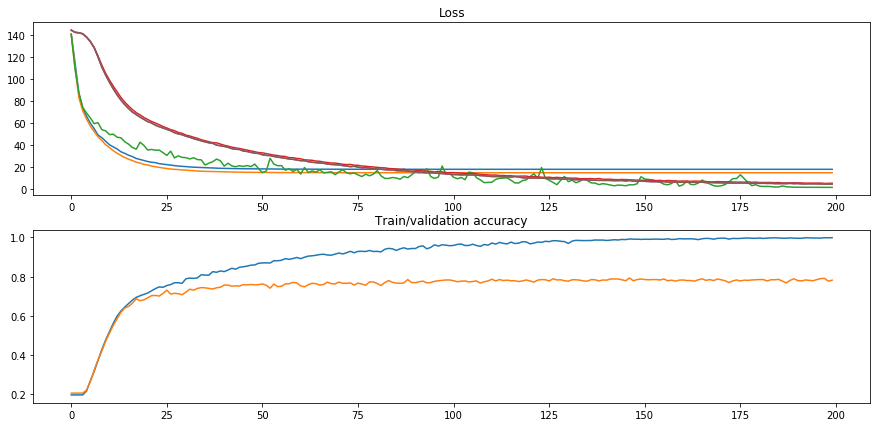

In [34]:
idx = best_idx
print(np.max(val_history[idx]), np.max(train_history[idx]))
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
for ii in [8, 9, 11, 16,17]:
    plt.plot(loss_history[ii]) 
plt.plot(loss_history[best_idx])
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history[idx])
plt.plot(val_history[idx])


# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [35]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.742000
